In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image
import matplotlib.pylab as plt

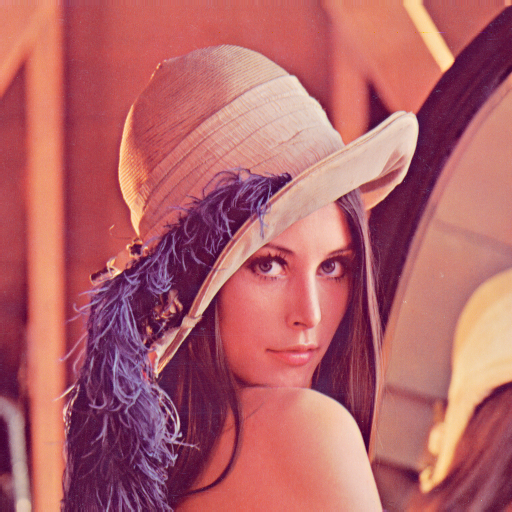

Image saved as output_image.jpg


In [ ]:
input_path = 'Lena.png'
output_path = 'output_image.jpg'
image = cv.imread(input_path)
cv2_imshow(image)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
cv.imwrite(output_path, image)
print(f"Image saved as {output_path}")

In [ ]:
def self_coded_histogram(image, num_bins=256):
    histogram = np.zeros(num_bins, dtype=np.uint32)

    if len(image.shape) == 3:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    height, width = image.shape

    for y in range(height):
        for x in range(width):
            pixel_value = image[y, x]
            histogram[pixel_value] += 1

    return histogram

def compute_and_compare_histograms(image, num_bins=256):
    self_coded_hist = self_coded_histogram(image, num_bins)
    if len(image.shape) == 3:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    opencv_hist = cv.calcHist([image], [0], None, [num_bins], [0, 256])

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Self-coded Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.plot(self_coded_hist)
    plt.xlim(0, num_bins)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.title("OpenCV Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.plot(opencv_hist)
    plt.xlim(0, num_bins)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

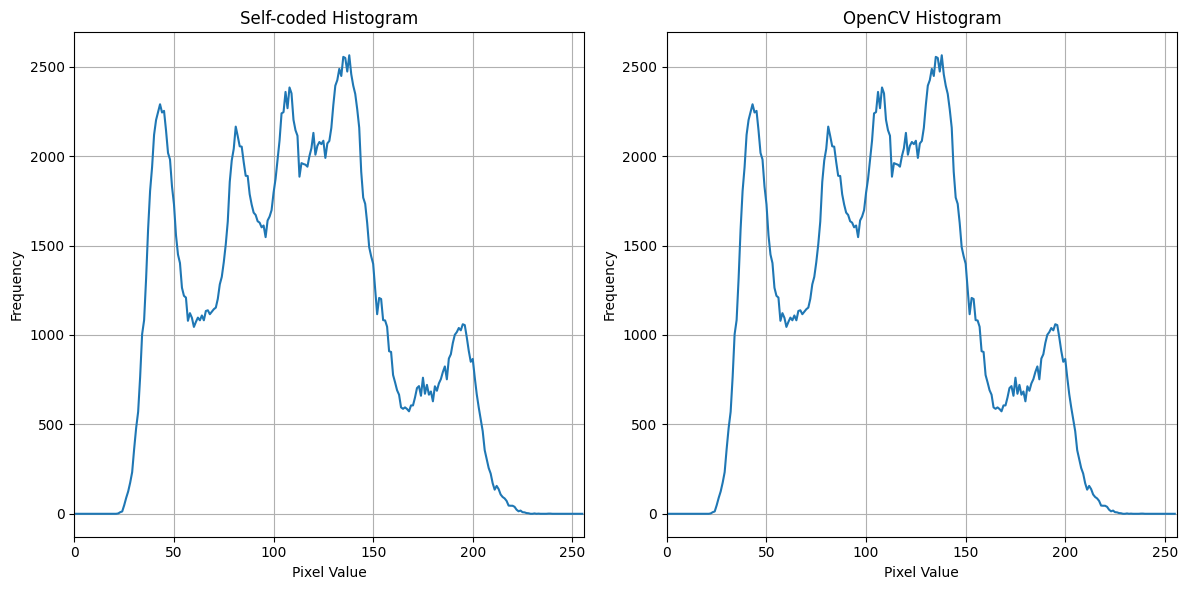

In [ ]:
num_bins = 256
compute_and_compare_histograms(image, num_bins)

In [ ]:
def linear_transform(image, a, b):
    img_array = np.array(image)
    transformed_image = a * img_array + b
    return Image.fromarray(np.uint8(transformed_image))

def gamma_correction(image, gamma):
    corrected_image = 255 * (image / 255) ** (1 / gamma)
    corrected_image = np.clip(corrected_image, 0, 255).astype(np.uint8)
    return corrected_image


def histogram_equalization(image):
    img_array = np.array(image)
    hist = np.array(self_coded_histogram(img_array))
    cdf = hist.cumsum()
    cdf_normalized = (cdf / cdf.max()) * 255
    equalized_image = np.interp(img_array, range(256), cdf_normalized)
    return Image.fromarray(np.uint8(equalized_image))

def linear_transform_cv(image, a, b):
    transformed_image = cv.convertScaleAbs(image, alpha=a, beta=b)
    return transformed_image

def gamma_correction_cv(image, gamma):
    gamma = 1 / gamma
    gamma_corrected = np.power(image / 255.0, gamma) * 255.0
    gamma_corrected = np.uint8(gamma_corrected)
    return gamma_corrected

def histogram_equalization_cv(image):
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    equalized_image = cv.equalizeHist(gray_image)
    return equalized_image

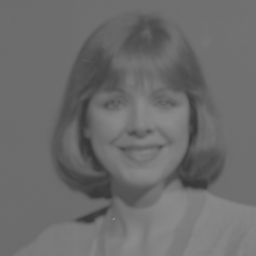

In [ ]:
image = cv.imread('Contrast.png')
cv2_imshow(image)

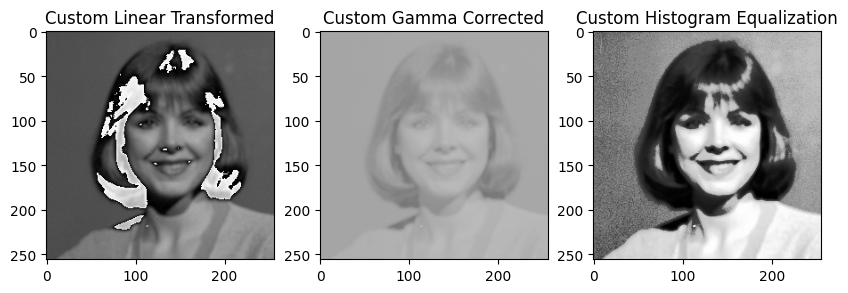

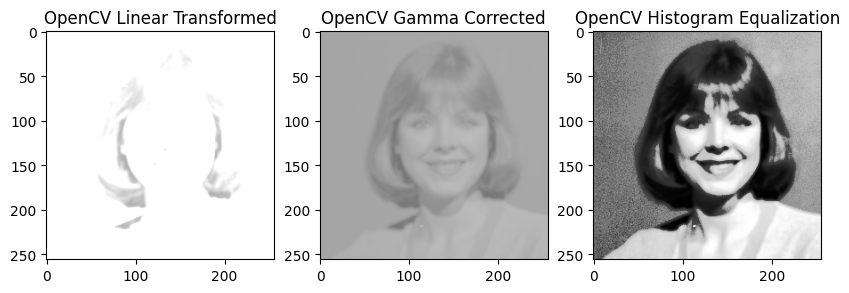

In [ ]:
linear_transformed = linear_transform(image, 3, 10)
gamma_corrected = gamma_correction(image, 2)
equalized_image = histogram_equalization(image)

linear_transformed_cv = linear_transform_cv(image, 3, 10)
gamma_corrected_cv = gamma_correction_cv(image, 2)
equalized_image_cv = histogram_equalization_cv(image)
equalized_image_cv = cv.cvtColor(equalized_image_cv, cv.COLOR_BGR2RGB)

linear_transformed = cv.cvtColor(np.array(linear_transformed), cv.COLOR_RGB2BGR)


plt.figure(figsize=(10, 10))
plt.subplot(131), plt.imshow(linear_transformed), plt.title('Custom Linear Transformed')
plt.subplot(132), plt.imshow(gamma_corrected), plt.title('Custom Gamma Corrected')
plt.subplot(133), plt.imshow(equalized_image), plt.title('Custom Histogram Equalization')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(131), plt.imshow(linear_transformed_cv), plt.title('OpenCV Linear Transformed')
plt.subplot(132), plt.imshow(gamma_corrected_cv), plt.title('OpenCV Gamma Corrected')
plt.subplot(133), plt.imshow(equalized_image_cv), plt.title('OpenCV Histogram Equalization')
plt.show()


In [ ]:
def median_filter(image, mask_size):
    img_array = np.array(image)
    height, width, channels = img_array.shape
    half_size = mask_size // 2
    output_image = np.zeros_like(img_array)
    for x in range(half_size, height - half_size):
        for y in range(half_size, width - half_size):
            window = img_array[x - half_size:x + half_size + 1, y - half_size:y + half_size + 1, :]
            output_image[x, y, :] = np.median(window, axis=(0, 1))
    return Image.fromarray(output_image.astype(np.uint8))

def smoothing_filter(image, mask_size):
    img_array = np.array(image)
    height, width, channels = img_array.shape
    half_size = mask_size // 2
    mask = np.ones((mask_size, mask_size), dtype=np.float32) / (mask_size * mask_size)
    output_image = np.zeros_like(img_array)
    for x in range(half_size, height - half_size):
        for y in range(half_size, width - half_size):
            window = img_array[x - half_size:x + half_size + 1, y - half_size:y + half_size + 1, :]
            for c in range(channels):
                output_image[x, y, c] = np.sum(window[:, :, c] * mask)
    return Image.fromarray(output_image.astype(np.uint8))

def sharpening_filter(image):
    img_array = np.array(image)
    height, width, channels = img_array.shape
    sharpen_mask = np.array([[-1, -1, -1],
                             [-1, 9, -1],
                             [-1, -1, -1]], dtype=np.float32)
    output_image = np.zeros_like(img_array)
    for c in range(channels):
        for x in range(1, height - 1):
            for y in range(1, width - 1):
                window = img_array[x - 1:x + 2, y - 1:y + 2, c]
                output_pixel = 0
                for i in range(3):
                    for j in range(3):
                        output_pixel += window[i, j] * sharpen_mask[i, j]
                output_image[x, y, c] = np.clip(output_pixel, 0, 255)
    return Image.fromarray(output_image.astype(np.uint8))

def apply_filter_cv(image, kernel):
    filtered_image = cv.filter2D(image, -1, kernel)
    return filtered_image

def median_filter_cv(image, kernel_size):
    median_filtered = cv.medianBlur(image, kernel_size)
    return median_filtered

def smoothing_filter_cv(image, kernel_size):
    kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size**2)
    smoothed = apply_filter_cv(image, kernel)
    return smoothed

def sharpening_filter_cv(image):
    kernel = np.array([[-1, -1, -1],
                       [-1, 9, -1],
                       [-1, -1, -1]], np.float32)
    sharpened = apply_filter_cv(image, kernel)
    return sharpened

In [ ]:
median_img = cv.imread('Median.jpg')
smooth_img = cv.imread('Lena.png')
smooth_img = cv.cvtColor(smooth_img, cv.COLOR_BGR2RGB)
sharpen_img = cv.imread('Sharpen.png')

median_img = np.array(median_img)
smooth_img = np.array(smooth_img)
sharpen_img = np.array(sharpen_img)

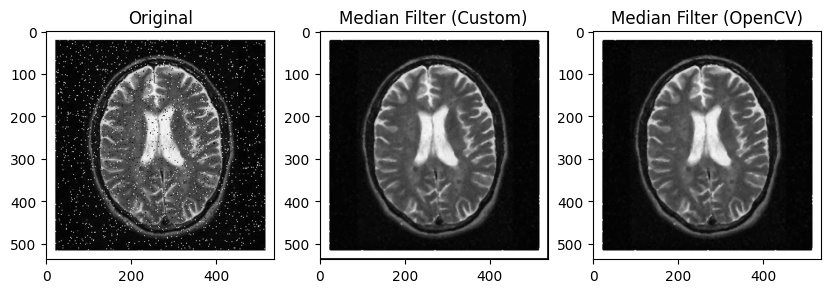

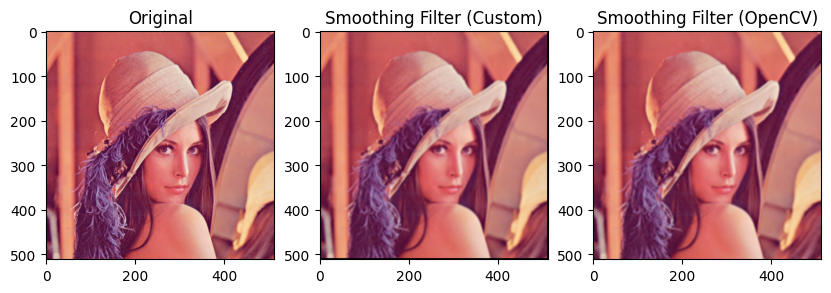

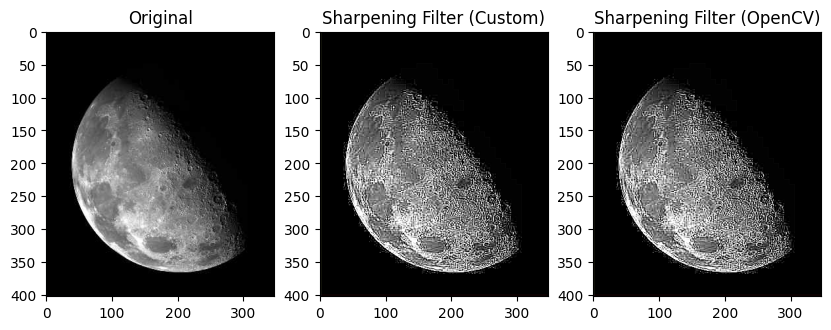

In [ ]:
median_filtered = median_filter(median_img, mask_size=5)
smoothing_filtered = smoothing_filter(smooth_img, mask_size=5)
sharpened = sharpening_filter(sharpen_img)

median_filtered_cv = median_filter_cv(median_img, kernel_size=5)
smoothing_filtered_cv = smoothing_filter_cv(smooth_img, kernel_size=5)
sharpened_cv = sharpening_filter_cv(sharpen_img)

median_filtered = cv.cvtColor(np.array(median_filtered), cv.COLOR_RGB2BGR)
sharpened = cv.cvtColor(np.array(sharpened), cv.COLOR_RGB2BGR)

sharpened_cv = cv.cvtColor(np.array(sharpened_cv), cv.COLOR_RGB2BGR)

plt.figure(figsize=(10, 10))
plt.subplot(131), plt.imshow(median_img), plt.title('Original')
plt.subplot(132), plt.imshow(median_filtered), plt.title('Median Filter (Custom)')
plt.subplot(133), plt.imshow(median_filtered_cv), plt.title('Median Filter (OpenCV)')

plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(131), plt.imshow(smooth_img), plt.title('Original')
plt.subplot(132), plt.imshow(smoothing_filtered), plt.title('Smoothing Filter (Custom)')
plt.subplot(133), plt.imshow(smoothing_filtered_cv), plt.title('Smoothing Filter (OpenCV)')

plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(131), plt.imshow(sharpen_img), plt.title('Original')
plt.subplot(132), plt.imshow(sharpened), plt.title('Sharpening Filter (Custom)')
plt.subplot(133), plt.imshow(sharpened_cv), plt.title('Sharpening Filter (OpenCV)')
plt.show()
